In [1]:
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader

transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2),
    ]
)
dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 10, 4, 2, 1, bias=False),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(0.2),
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(10, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(0.2),
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(20, 40, 4, 2, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(0.2),
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(40, 1, 3, 1, 0, bias=False), nn.Sigmoid()
        )

    def forward(self, x):
        # encoding
        layer_1_out = self.layer_1(x)  # (N, 10, 14, 14)
        layer_2_out = self.layer_2(layer_1_out)  # (N, 20, 7, 7)
        layer_3_out = self.layer_3(layer_2_out)  # (N, 40, 3, 3)
        # classify
        out = self.last_layer(layer_3_out).squeeze()
        return out


In [5]:
discriminator = Discriminator()

In [6]:
for batch in loader:
    x = batch[0]
    break
    
with torch.no_grad():
    # encoding
    layer_1_out = discriminator.layer_1(x)  # (N, 10, 14, 14)
    layer_2_out = discriminator.layer_2(layer_1_out)  # (N, 20, 7, 7)
    layer_3_out = discriminator.layer_3(layer_2_out)  # (N, 40, 3, 3)
    # classify
    out = discriminator.last_layer(layer_3_out).squeeze()

In [7]:
out[:10]

tensor([0.4386, 0.5597, 0.5724, 0.4969, 0.4873, 0.4456, 0.5770, 0.5647, 0.4118,
        0.4347])

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ## layer 4
        self.layer_4 = nn.Sequential(
            nn.ConvTranspose2d(100, 40, 4, 2, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.ConvTranspose2d(40, 40, 2, 1, bias=False),
            nn.BatchNorm2d(40),
            nn.ReLU(),
        )
        self.layer_5 = nn.Sequential(
            nn.ConvTranspose2d(40, 20, 4, 2, 1, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
        )
        self.layer_6 = nn.Sequential(
            nn.ConvTranspose2d(20, 10, 4, 2, 1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )
        self.last_layer = nn.Sequential(
            nn.ConvTranspose2d(10, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        # decoding
        layer_4_out = self.layer_4(z)  # (N, 40, 7, 7)
        layer_5_out = self.layer_5(layer_4_out)  # (N, 20, 14, 14)
        layer_6_out = self.layer_6(layer_5_out)  # (N, 40, 28, 28)
        # transform to rgb
        out = self.last_layer(layer_6_out) # (N, 1, 28, 28)
        return out

In [9]:
generator = Generator()

In [10]:
z = torch.rand(128, 100, 3, 3)

with torch.no_grad():
    # decoding
    layer_4_out = generator.layer_4(z)  # (N, 40, 7, 7)
    layer_5_out = generator.layer_5(layer_4_out)  # (N, 20, 14, 14)
    layer_6_out = generator.layer_6(layer_5_out)  # (N, 10, 28, 28)
    # transform to rgb
    out = generator.last_layer(layer_6_out)  # (N, 1, 28, 28)

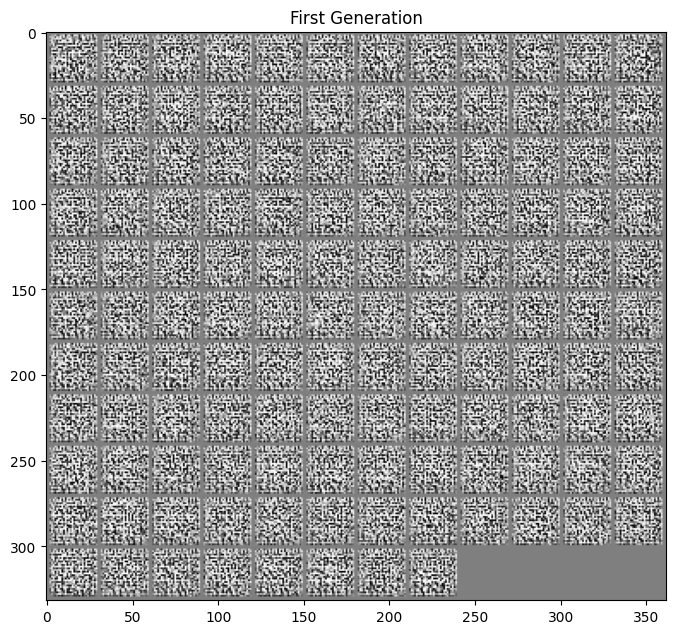

In [266]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


out_x_grid = make_grid(out, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("First Generation")
plt.imshow(out_x_grid[0], cmap="gray")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
_ = discriminator.to(device)
_ = generator.to(device)

In [13]:
import torch.optim as optim
import torch.functional as F
from tqdm import tqdm


bce_loss_fn = nn.BCEWithLogitsLoss()

discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002)
n_epochs = 30

for epoch in range(n_epochs):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
        generator.train()
        discriminator.train()
        
        x = batch[0].to(device)
        batch_size = x.size()[0]

        #
        # 1. get discriminator loss from real data
        #
        discriminator_opt.zero_grad()
        real_D_score = discriminator(x)
        real_target = torch.ones_like(real_D_score).to(device)
        real_D_loss = bce_loss_fn(real_D_score, real_target)
        #
        # 2. get discriminator loss from fake data
        #
        z = torch.randn((batch_size, 100, 3, 3)).to(device)
        fake_data = generator(z)

        fake_D_score = discriminator(fake_data)
        fake_target = torch.zeros_like(fake_D_score).to(device)
        fake_D_loss = bce_loss_fn(fake_D_score, fake_target)
        #
        # 3. get discriminator loss and update discriminator
        #
        D_loss = real_D_loss + fake_D_loss
        D_loss.backward()
        discriminator_opt.step()

        #
        # 4. get generator loss and update generator
        #
        generator_opt.zero_grad()
        z = torch.randn((batch_size, 100, 3, 3)).to(device)
        generated_data = generator(z)

        generate_D_score = discriminator(generated_data)
        generate_target = torch.ones_like(generate_D_score).to(device)

        G_loss = bce_loss_fn(generate_D_score, generate_target)

        G_loss.backward()
        generator_opt.step()
        
        epoch_D_loss += D_loss.item() * len(x) / len(loader.dataset)
        epoch_G_loss += G_loss.item() * len(x) / len(loader.dataset)
        
    log_string = f"Loss at epoch {epoch + 1} - D_loss : {epoch_D_loss:.4f}, G_loss : {epoch_G_loss:.4f}"

    print(log_string)

Epoch 1/30: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]


Loss at epoch 1 - D_loss : 1.1159, G_loss : 0.6474


Epoch 2/30: 100%|██████████| 469/469 [00:11<00:00, 39.55it/s]


Loss at epoch 2 - D_loss : 1.0514, G_loss : 0.6784


Epoch 3/30: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]


Loss at epoch 3 - D_loss : 1.0122, G_loss : 0.6912


Epoch 4/30: 100%|██████████| 469/469 [00:12<00:00, 38.18it/s]


Loss at epoch 4 - D_loss : 1.0078, G_loss : 0.6926


Epoch 5/30: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]


Loss at epoch 5 - D_loss : 1.0127, G_loss : 0.6919


Epoch 6/30: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]


Loss at epoch 6 - D_loss : 1.0523, G_loss : 0.6836


Epoch 7/30: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]


Loss at epoch 7 - D_loss : 1.1413, G_loss : 0.6583


Epoch 8/30: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]


Loss at epoch 8 - D_loss : 1.0860, G_loss : 0.6693


Epoch 9/30: 100%|██████████| 469/469 [00:12<00:00, 38.97it/s]


Loss at epoch 9 - D_loss : 1.0650, G_loss : 0.6728


Epoch 10/30: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]


Loss at epoch 10 - D_loss : 1.0456, G_loss : 0.6784


Epoch 11/30: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]


Loss at epoch 11 - D_loss : 1.0284, G_loss : 0.6843


Epoch 12/30: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]


Loss at epoch 12 - D_loss : 1.0222, G_loss : 0.6868


Epoch 13/30: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]


Loss at epoch 13 - D_loss : 1.0218, G_loss : 0.6868


Epoch 14/30: 100%|██████████| 469/469 [00:12<00:00, 38.57it/s]


Loss at epoch 14 - D_loss : 1.0165, G_loss : 0.6890


Epoch 15/30: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]


Loss at epoch 15 - D_loss : 1.0161, G_loss : 0.6889


Epoch 16/30: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]


Loss at epoch 16 - D_loss : 1.0156, G_loss : 0.6894


Epoch 17/30: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]


Loss at epoch 17 - D_loss : 1.0131, G_loss : 0.6904


Epoch 18/30: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]


Loss at epoch 18 - D_loss : 1.0159, G_loss : 0.6892


Epoch 19/30: 100%|██████████| 469/469 [00:12<00:00, 38.60it/s]


Loss at epoch 19 - D_loss : 1.0172, G_loss : 0.6890


Epoch 20/30: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]


Loss at epoch 20 - D_loss : 1.0187, G_loss : 0.6882


Epoch 21/30: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Loss at epoch 21 - D_loss : 1.0203, G_loss : 0.6874


Epoch 22/30: 100%|██████████| 469/469 [00:12<00:00, 38.43it/s]


Loss at epoch 22 - D_loss : 1.0207, G_loss : 0.6872


Epoch 23/30: 100%|██████████| 469/469 [00:12<00:00, 38.15it/s]


Loss at epoch 23 - D_loss : 1.0232, G_loss : 0.6864


Epoch 24/30: 100%|██████████| 469/469 [00:12<00:00, 38.73it/s]


Loss at epoch 24 - D_loss : 1.0231, G_loss : 0.6859


Epoch 25/30: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]


Loss at epoch 25 - D_loss : 1.0255, G_loss : 0.6850


Epoch 26/30: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]


Loss at epoch 26 - D_loss : 1.0259, G_loss : 0.6850


Epoch 27/30: 100%|██████████| 469/469 [00:12<00:00, 38.41it/s]


Loss at epoch 27 - D_loss : 1.0249, G_loss : 0.6857


Epoch 28/30: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]


Loss at epoch 28 - D_loss : 1.0231, G_loss : 0.6856


Epoch 29/30: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]


Loss at epoch 29 - D_loss : 1.0232, G_loss : 0.6853


Epoch 30/30: 100%|██████████| 469/469 [00:12<00:00, 38.92it/s]

Loss at epoch 30 - D_loss : 1.0253, G_loss : 0.6850


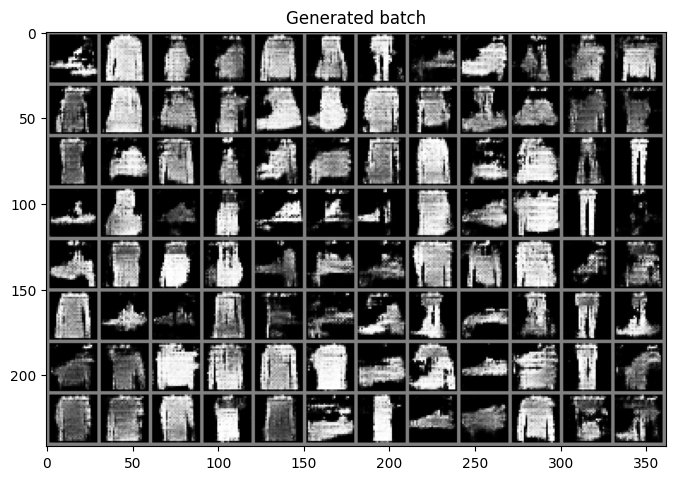

In [17]:
generated_x = generated_data.cpu()
generated_x_grid = make_grid(generated_x, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(generated_x_grid[0], cmap="gray")

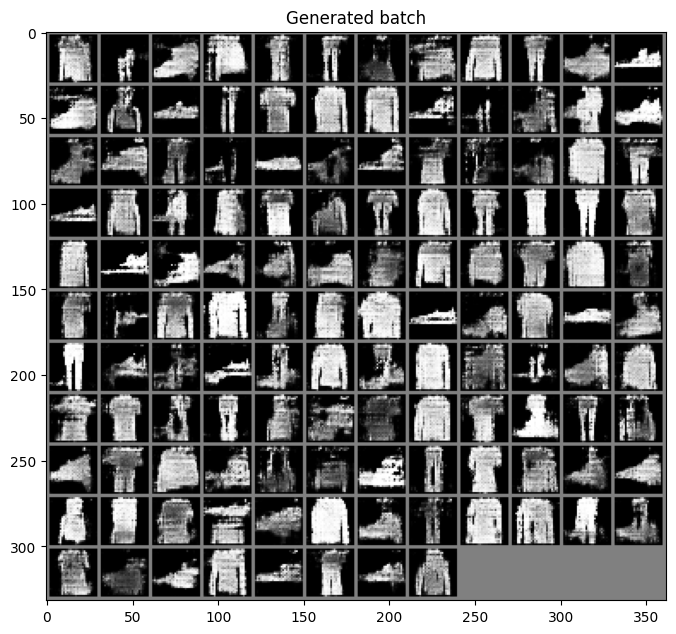

In [19]:
generator.eval()
with torch.no_grad():    
    random_z = torch.randn((128, 100, 3, 3)).to(device)
    generated_x = generator(random_z)

generated_x = generated_x.cpu()
generated_x_grid = make_grid(generated_x, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(generated_x_grid[0], cmap="gray")